# CATCHM pipeline [demo]

This notebook is in many ways identical to the *CATCHM_demo.ipynb* notebook.
However, in this notebook CATCHM is implemented as a [ScikitLearn compatible pipeline object](https://scikit-learn.org/stable/modules/compose.html). 
This allows you to experiment with different classifiers and replace the default [XGBoost model](https://xgboost.readthedocs.io/en/stable/python/index.html).


In [1]:
from catchm.embeddings import InductiveDeepwalk
from sklearn.pipeline import Pipeline
import xgboost as xgb
import pandas as pd
import numpy as np
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [2]:
# Parameters
dimensions = 32
walk_len = 80
walk_num = 10
window_size = 5
# the 'workers' parameter is used for multi-processing.
workers = 4

In [3]:
default_xgboost_params = {'eval_metric' : ['auc','aucpr', 'logloss'],
                          'n_estimators':300, 
                          'n_jobs':8, 
                          'learning_rate':0.1, 
                          'seed':42, 
                          'colsample_bytree' : 0.6,
                          'colsample_bylevel':0.9, 
                          'subsample' : 0.9}

## Load Data

In [4]:
### PATH TO DEMO DATA ###
demo_data_path = './transactions/transactions.txt'

df = pd.read_json(demo_data_path,  lines=True, convert_dates=[4])
# Transform fourth column to datetime format
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4])
# Sort dataframe by datetime
df = df.sort_values('transactionDateTime')
# Create a transaction ID
df.loc[:, 'TX_ID'] = range(df.shape[0])

In [5]:
# Split into train and test set
df_train = df.iloc[:400000]
df_test = df.iloc[400000:500000]

In [6]:
embedder = InductiveDeepwalk(dimensions=dimensions, walk_len = walk_len, walk_num=walk_num, workers=workers, verbose=0)
classifier = xgb.XGBClassifier(**default_xgboost_params)

In [7]:
X_train = []
for i, row in df_train.iterrows():
    X_train.append((str(row.customerId), str(row.merchantName)))
    
y_train = df_train.isFraud

In [8]:
X_test = []
for i, row in df_test.iterrows():
    X_test.append((str(row.customerId), str(row.merchantName)))
    
y_test = df_test.isFraud

In [9]:
embedder.fit(X_train, y_train)

InductiveDeepwalk(dimensions=32, epochs=5, verbose=0, walk_len=80, walk_num=10,
                  window_size=5, workers=4)

In [10]:
pipe = Pipeline([('embedder', embedder), ('classifier', classifier)])

In [11]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('embedder',
                 InductiveDeepwalk(dimensions=32, epochs=5, verbose=0,
                                   walk_len=80, walk_num=10, window_size=5,
                                   workers=4)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.9, colsample_bynode=1,
                               colsample_bytree=0.6,
                               eval_metric=['auc', 'aucpr', 'logloss'], gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=8, num_parallel_tree=1,
                               objective='

In [12]:
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

100%|██████████| 4/4 [00:37<00:00,  9.35s/it]


## Evaluation

In [13]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.24


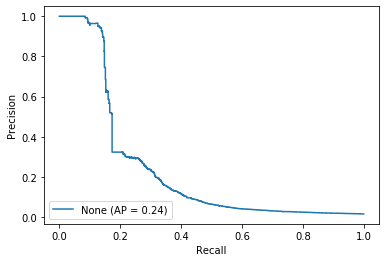

In [14]:
fig = plot_ap(y_test, y_pred_proba)

In [15]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.2759


In [16]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[97432  1023]
 [ 1134   411]]


In [17]:
roc_auc_score(y_test, y_pred_proba)

0.7549432157250229